**In this file we use Translation DeepSentiPers Dataset for binary SA**
> We are going to binarized DS by NN approch, and do not omite any record.


# Prepare  sys

## check GPU

In [ ]:
!nvidia-smi #The NVIDIA System Management Interface (nvidia-smi) is a command line utility,
            # intended to aid in the management and monitoring of NVIDIA GPU devices. 

Tue Jul  6 13:22:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install required packages

In [ ]:
!pip install -q transformers==3

!pip install -q hazm
!pip install -q clean-text[gpl]

     |████████████████████████████████| 757kB 4.3MB/s 
     |████████████████████████████████| 3.0MB 18.8MB/s 
     |████████████████████████████████| 901kB 34.5MB/s 
     |████████████████████████████████| 1.2MB 36.8MB/s 
     |████████████████████████████████| 317kB 5.2MB/s 
     |████████████████████████████████| 235kB 34.1MB/s 
     |████████████████████████████████| 1.4MB 32.1MB/s 
     |████████████████████████████████| 133kB 5.8MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 245kB 23.6MB/s 


## Import required packages

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import requests
import os
import io
import re
import json
import copy
import collections

# Translation Dataset

We are going to use [Translation DeepSentiPers Dataset](https://github.com/JoyeBright/DeepSentiPers/tree/master/Dataset) here.

<table style="width:100%">
  <tr>
    <th>Polarity</th>
    <th>-2</th>
    <th>-1</th>
    <th>0</th>
    <th>+1</th>
    <th>+2</th>
  </tr>
  <tr>
    <td>Original (SentiPers) DS</td>
    <td>28</td>
    <td>513</td>
    <td>2409</td>
    <td>1623</td>
    <td>988</td>
  </tr>
  <tr>
    <td>Translation DS</td>
    <td>56</td>
    <td>1026</td>
    <td>4818</td>
    <td>3246</td>
    <td>1976</td>
  </tr>
</table>



## Load

In [ ]:
url = "https://raw.githubusercontent.com/JoyeBright/DeepSentiPers/master/Dataset/translation.csv" 
download = requests.get(url).content
data = pd.read_csv(io.StringIO(download.decode('utf-8')))
data.set_axis(['comment', 'rate'], axis='columns', inplace=True)
print('The first 5 rows of the dataset: \n', data.head())

The first 5 rows of the dataset: 
                                              comment  rate
0  کارتهای حافظه معمولاً در تلفنهای همراه به جای ...     0
1          وضوح نمایشگر iPod دقیقاً مشابه آیفون است.     0
2  اما صفحه نمایش JVC GZ-MG335 از نوع TFT 2.7 این...     0
3  سرانجام ، در پشت گوشی ، دوربین از یک فلاش بلند...     0
4  در انتهای گوشی ، ایسوس درگاهی را به نام MHL قر...     0


In [ ]:
# print data information
print('data information: \n')
print(data.info(), '\n')

data information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14045 entries, 0 to 14044
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  14045 non-null  object
 1   rate     14045 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 219.6+ KB
None 



## Preprocessing

In [ ]:
unique_rates = list(sorted(data['rate'].unique()))
print(f'We have #{len(unique_rates)} in translation DS:: {unique_rates}')

We have #5 in translation DS:: [-2, -1, 0, 1, 2]


In [ ]:
fig = go.Figure()

groupby_rate = data.groupby('rate')['rate'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Binarization DS using NN approch

NN: Considering neutral emotions as negative

To a binary form of negative (0) or positive (1) with a threshold. If the rate is greater than 0, it labeled as positive otherwise specified as negative.

In [ ]:
def rate_to_label(rate):
    if rate < 1:
        return 'negative'
    else:
      return 'positive'


In [ ]:
data['label'] = data['rate'].apply(lambda r: rate_to_label(r))
labels = list(sorted(data['label'].unique()))

data.head()

,comment,rate,label
0,کارتهای حافظه معمولاً در تلفنهای همراه به جای ...,0,negative
1,وضوح نمایشگر iPod دقیقاً مشابه آیفون است.,0,negative
2,اما صفحه نمایش JVC GZ-MG335 از نوع TFT 2.7 این...,0,negative
3,سرانجام ، در پشت گوشی ، دوربین از یک فلاش بلند...,0,negative
4,در انتهای گوشی ، ایسوس درگاهی را به نام MHL قر...,0,negative


In [ ]:
fig = go.Figure()

Tgroupby_label = data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(Tgroupby_label.index)),
    y=Tgroupby_label.tolist(),
    text=Tgroupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Cleaning 
is the final step in this section, and becase **DeepSentiPers** had five different preprocessing steps were applied to all the sentences (Normalization, Punctuation rmoval, Single character removal, Digits removal and Lemmatization), so Our cleaned method includes these steps:
- fixing unicodes
- removing specials like an email, url, new lines, ...
- cleaning HTMLs
- removing emojis

In [ ]:
import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,                 # fix various unicode errors
        to_ascii=False,                   # transliterate to closest ASCII representation
        lower=True,                       # lowercase text
        no_line_breaks=True,              # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                     # replace all URLs with a special token
        no_emails=True,                   # replace all email addresses with a special token
        no_phone_numbers=True,            # replace all phone numbers with a special token
        no_numbers=False,                 # replace all numbers with a special token
        no_digits=False,                  # replace all digits with a special token
        no_currency_symbols=True,         # replace all currency symbols with a special token
        no_punct=False,                   # remove punctuations
        replace_with_url="",              # instead of removing URL replace them by noyhing
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",  
        #lang="en"                       # set to 'de' for German special handling
        # So far, only English and German are fully supported. It should work for the majority of western languages.
    )


    # cleaning htmls
    text = cleanhtml(text) 
   
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
# cleaning comments
data['cleaned_comment'] = data['comment'].apply(cleaning)

data.head()

,comment,rate,label,cleaned_comment
0,کارتهای حافظه معمولاً در تلفنهای همراه به جای ...,0,negative,کارتهای حافظه معمولاً در تلفنهای همراه به جای ...
1,وضوح نمایشگر iPod دقیقاً مشابه آیفون است.,0,negative,وضوح نمایشگر ipod دقیقاً مشابه آیفون است.
2,اما صفحه نمایش JVC GZ-MG335 از نوع TFT 2.7 این...,0,negative,اما صفحه نمایش jvc gz-mg335 از نوع tft 2.7 این...
3,سرانجام ، در پشت گوشی ، دوربین از یک فلاش بلند...,0,negative,سرانجام ، در پشت گوشی ، دوربین از یک فلاش بلند...
4,در انتهای گوشی ، ایسوس درگاهی را به نام MHL قر...,0,negative,در انتهای گوشی ، ایسوس درگاهی را به نام mhl قر...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14045 entries, 0 to 14044
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comment          14045 non-null  object
 1   rate             14045 non-null  int64 
 2   label            14045 non-null  object
 3   cleaned_comment  14045 non-null  object
dtypes: int64(1), object(3)
memory usage: 439.0+ KB


In [ ]:
data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,کارتهای حافظه معمولاً در تلفنهای همراه به جای ...,negative
1,وضوح نمایشگر ipod دقیقاً مشابه آیفون است.,negative
2,اما صفحه نمایش jvc gz-mg335 از نوع tft 2.7 این...,negative
3,سرانجام ، در پشت گوشی ، دوربین از یک فلاش بلند...,negative
4,در انتهای گوشی ، ایسوس درگاهی را به نام mhl قر...,negative


In [ ]:
print(f'We have #{len(labels)} labels: {labels}')

We have #2 labels: ['negative', 'positive']


In [ ]:
# See the data number of sentence in each category and is it balanced?
GroupbyLabel = data.groupby('label')['label'].count()

GroupbyLabel = dict(GroupbyLabel)
print(GroupbyLabel)

{'negative': 6189, 'positive': 7856}


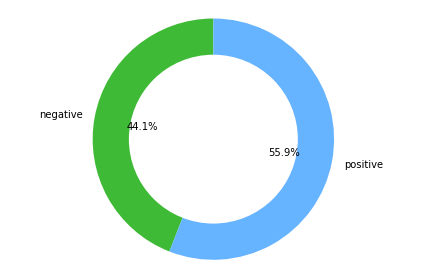

In [ ]:
labels = list(GroupbyLabel.keys())
sizes = list(GroupbyLabel.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
plt.show()

### Shuffle the DS

In [ ]:
new_data = data
new_data = new_data.sample(frac=1).reset_index(drop=True)# we shuffle the order of the DataFrame's rows,
                                                          # so that all Type's are mixed.
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14045 entries, 0 to 14044
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  14045 non-null  object
 1   label    14045 non-null  object
dtypes: object(2)
memory usage: 219.6+ KB


# Train,Validation,Test split

We need to split the balanced cleaned dataset into train, valid and test sets due to size of the data. 

In this tutorial, we have considered a rate of **0.1** for both *valid*, *test* sets. For splitting, we use `train_test_split` provided by Sklearn package with stratifying on the label for preserving the distribution balance.

In [ ]:
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(11376, 3)
(1264, 3)
(1405, 3)


In [ ]:
new_data.head()

,comment,label,label_id
0,با توجه به ضخامت کاهش وزن دستگاه ، به ناچار عم...,negative,0
1,سنسور تصویر 16 مگاپیکسلی با لنزهای فوق العاده ...,positive,1
2,اما من در نهايت 650d رو انتخاب کردم.,negative,0
3,اما می‌توان گفت که کانن sx40 hs از نظر سنسور ت...,positive,1
4,صفحات باز را بکشید ، بدون کوچکترین مشکلی یا کا...,positive,1


## Using PyTorch

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

### Configuration

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [ ]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())


{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 100000
}



### Input Embeddings

In [ ]:
idx = np.random.randint(0, len(train))
sample_comment = train.iloc[idx]['comment']
sample_label = train.iloc[idx]['label']

print(f'Sample: \n{sample_comment}\n{sample_label}')

Sample: 
با تشکر از کالاهای دیگری که تاکنون بدست آورده ام ، وقت کافی برای کار با آن ندارم اما بسیار خوشحالم که فقط به برخی از دوستان قابل شارژ خود اطلاع دادم که از این ویژگی های قیمت در این بازار خوشحالم
positive


In [ ]:
tokens = tokenizer.tokenize(sample_comment)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Comment: {sample_comment}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

  Comment: با تشکر از کالاهای دیگری که تاکنون بدست آورده ام ، وقت کافی برای کار با آن ندارم اما بسیار خوشحالم که فقط به برخی از دوستان قابل شارژ خود اطلاع دادم که از این ویژگی های قیمت در این بازار خوشحالم
   Tokens: با تشکر از کالاهای دیگری که تاکنون بدست اورده ام ، وقت کافی برای کار با ان ندارم اما بسیار خوشحالم که فقط به برخی از دوستان قابل شارژ خود اطلاع دادم که از این ویژگی های قیمت در این بازار خوشحالم
Token IDs: [2799, 9093, 2791, 6565, 3574, 2800, 4971, 5529, 5294, 2822, 1348, 4244, 4578, 2831, 2867, 2799, 2808, 9250, 2949, 3177, 18406, 2800, 3765, 2789, 3237, 2791, 5440, 3496, 7450, 2847, 4367, 10315, 2800, 2791, 2802, 4274, 6343, 3377, 2786, 2802, 3179, 18406]


In [ ]:
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2,  2799,  9093,  2791,  6565,  3574,  2800,  4971,  5529,  5294,
          2822,  1348,  4244,  4578,  2831,  2867,  2799,  2808,  9250,  2949,
          3177, 18406,  2800,  3765,  2789,  3237,  2791,  5440,  3496,  7450,
          2847,     4]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])


### Dataset

In [ ]:
class TranslationDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Translation DeepSP Dataset. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TranslationDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = ['negative', 'positive']
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['comment'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['من خودم گوشي رو دارم، حتي يک بار هم هنگ نکرده توي اين مدتي که داشتمش به جز دوربينش که در شب واقعا بدرد نخوره، در بقيه موارد، کار با گوشي، بلندگو، دو سيم کارته بودنش کار باهاش بسيار خوب هستش.', 'در نهایت می\u200cتوان نقطه ضعف اصلی این تبلت را در طراحی ساخت آن دانست، جایی که از یک تبلت با این امکانات قدرت، انتظار بیشتری می\u200cرفت ولی توسط سامسونگ برآورده نشد.', 'مدتی این اسکنر را خریداری کردم.', 'خيلي قويه..', 'از رقبای دیگر در دیگر برندها نیز می\u200cتوان به htc desire c، htc one حتی htc explorer اشاره کرد.', 'بيشتر گوشي هاي سوني اريکسون همه چيز دارن به جز صدا اين که ديگه پرسيدن نداره //.', 'عالی من آن را دوست داشتم همیشه کار سامسونگ عالی است', 'با این حال اگر از باتری سلولی بر روی آن استفاده شده بود، باز هم شارژدهی بیشتری را از آن شاهد بودیم.', 'زاویه دید این صفحه نمایش بسیار عالی است به گونه ای که حتی اگر از بالا به پایین صفحه را نگاه کنید ، متوجه هیچ تغییری در کیفیت صفحه نمی شوید.', 'صرف نظر از عمل

In [ ]:
sample_test = next(iter(test_data_loader))
print(sample_test.keys())

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids'])


### Model

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Tue Jul  6 13:22:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    35W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['bert.embeddings.position_ids']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
# sample data output

sample_data_comment = sample_data['comment']
sample_data_input_ids = sample_data['input_ids']
sample_data_attention_mask = sample_data['attention_mask']
sample_data_token_type_ids = sample_data['token_type_ids']
sample_data_targets = sample_data['targets']

# available for using in GPU
sample_data_input_ids = sample_data_input_ids.to(device)
sample_data_attention_mask = sample_data_attention_mask.to(device)
sample_data_token_type_ids = sample_data_token_type_ids.to(device)
sample_data_targets = sample_data_targets.to(device)


# outputs = F.softmax(
#     pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids), 
#     dim=1)

outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

print(outputs[:5, :])
print(preds[:5])

tensor([[0.3704, 0.1862],
        [0.1949, 0.4970],
        [0.2095, 0.5296],
        [0.3505, 0.6056],
        [0.3852, 0.8078]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([0, 1, 1, 1, 1], device='cuda:0')


### Training

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)


Epoch: 2/3...Step: 1000...Train Loss: 0.402272...Train Acc: 0.819...Valid Loss: 0.396658...Valid Acc: 0.833...
Validation loss decreased (inf --> 0.396658).  Saving model ...




Epoch: 3/3...Step: 2000...Train Loss: 0.247697...Train Acc: 0.905...Valid Loss: 0.407917...Valid Acc: 0.850...



### Prediction

In [ ]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

print(preds.shape, probs.shape)


(1405,) (1405, 2)


In [ ]:
y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=label_list))

F1: 0.8223978671230194

              precision    recall  f1-score   support

    negative       0.79      0.82      0.80       619
    positive       0.85      0.82      0.84       786

    accuracy                           0.82      1405
   macro avg       0.82      0.82      0.82      1405
weighted avg       0.82      0.82      0.82      1405



## Using TensorFlow

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features

import tensorflow as tf

### Configuration

In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 100000
}



### Input Embeddings / Dataset

In [ ]:
class InputExample:
    """ A single example for simple sequence classification. """

    def __init__(self, guid, text_a, text_b=None, label=None):
        """ Constructs a InputExample. """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def make_examples(tokenizer, x, y=None, maxlen=128, output_mode="classification", is_tf_dataset=True):
    examples = []
    y = y if isinstance(y, list) or isinstance(y, np.ndarray) else [None] * len(x)

    for i, (_x, _y) in tqdm(enumerate(zip(x, y)), position=0, total=len(x)):
        guid = "%s" % i
        label = int(_y)
        
        if isinstance(_x, str):
            text_a = _x
            text_b = None
        else:
            assert len(_x) == 2
            text_a = _x[0]
            text_b = _x[1]
        
        examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    
    features = glue_convert_examples_to_features(
        examples, 
        tokenizer, 
        maxlen, 
        output_mode=output_mode, 
        label_list=list(np.unique(y)))

    all_input_ids = []
    all_attention_masks = []
    all_token_type_ids = []
    all_labels = []

    for f in tqdm(features, position=0, total=len(examples)):
        if is_tf_dataset:
            all_input_ids.append(tf.constant(f.input_ids))
            all_attention_masks.append(tf.constant(f.attention_mask))
            all_token_type_ids.append(tf.constant(f.token_type_ids))
            all_labels.append(tf.constant(f.label))
        else:
            all_input_ids.append(f.input_ids)
            all_attention_masks.append(f.attention_mask)
            all_token_type_ids.append(f.token_type_ids)
            all_labels.append(f.label)

    if is_tf_dataset:
        dataset = tf.data.Dataset.from_tensor_slices(({
            'input_ids': all_input_ids,
            'attention_mask': all_attention_masks,
            'token_type_ids': all_token_type_ids
        }, all_labels))

        return dataset, features
    
    xdata = [np.array(all_input_ids), np.array(all_attention_masks), np.array(all_token_type_ids)]
    ydata = all_labels

    return [xdata, ydata], features

In [ ]:
train_dataset_base, train_examples = make_examples(tokenizer, x_train, y_train, maxlen=128)
valid_dataset_base, valid_examples = make_examples(tokenizer, x_valid, y_valid, maxlen=128)

test_dataset_base, test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128)
[xtest, ytest], test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128, is_tf_dataset=False)

In [ ]:
for value in train_dataset_base.take(1):
    print(f'     input_ids: {value[0]["input_ids"]}')
    print(f'attention_mask: {value[0]["attention_mask"]}')
    print(f'token_type_ids: {value[0]["token_type_ids"]}')
    print(f'        target: {value[1]}')

     input_ids: [    2  2842  6558  4643  2038  2840  6052  1348 16774  2038  1381  2004
  3163  2820  3655  5938 14873  8568  2011  3679  2038  2800  8065  2014
  2789  3430  3021  2016 11612  2014  2800  2786  3256  5668 56947 49171
  2008  1348  2786  8997  7691  3907  1348  2867  2799  4643  2038  1348
 20311  1348  2897 10815  2015 64488 19222  2867 28313  5139 19006  2007
  4124 38644  1012     4     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
attention_mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
def get_training_dataset(dataset, batch_size):
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)

    return dataset

def get_validation_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
train_dataset = get_training_dataset(train_dataset_base, TRAIN_BATCH_SIZE)
valid_dataset = get_training_dataset(valid_dataset_base, VALID_BATCH_SIZE)

train_steps = len(train_examples) // TRAIN_BATCH_SIZE
valid_steps = len(valid_examples) // VALID_BATCH_SIZE

train_steps, valid_steps

(711, 79)

### Model

In [ ]:
def build_model(model_name, config, learning_rate=3e-5):
    model = TFBertForSequenceClassification.from_pretrained(model_name, config=config)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

In [ ]:
model = build_model(MODEL_NAME_OR_PATH, config, learning_rate=LEARNING_RATE)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

In [ ]:
%%time

r = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    epochs=EPOCHS,
    verbose=1)

final_accuracy = r.history['val_accuracy']
print('FINAL ACCURACY MEAN: ', np.mean(final_accuracy))

Epoch 1/3
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
711/711 [==============================] - 658s 895ms/step - loss: 0.4257 - accuracy: 0.8018 - val_loss: 0.3322 - val_accuracy: 0.8528
Epoch 2/3
711/711 [==============================] - 631s 888ms/step - loss: 0.2617 - accuracy: 0.8955 - val_loss: 0.3584 - val_accuracy: 0.8536
Epoch 3/3
711/711 [==============================] - 631s 887ms/step - loss: 0.1508 - accuracy: 0.9471 - val_loss: 0.3532 - val_accuracy: 0.8821
FINAL ACCURACY MEAN:  0.8628692030906677
CPU times: user 7min 24s, sys: 3min 10s, total: 10min 34s
Wall time: 32min


In [ ]:
# save the model
model.save_pretrained(os.path.dirname(OUTPUT_PATH))

### Evaluation / Prediction

In [ ]:
ev = model.evaluate(test_dataset_base.batch(TEST_BATCH_SIZE))
print()
print(f'Evaluation: {ev}')
print()

predictions = model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

print()
print(classification_report(ytest, ypred, target_names=labels))
print()

print(f'F1: {f1_score(ytest, ypred, average="weighted")}')

88/88 [==============================] - 26s 298ms/step - loss: 0.3929 - accuracy: 0.8633

Evaluation: [0.3929445147514343, 0.863345205783844]


              precision    recall  f1-score   support

    negative       0.84      0.85      0.85       619
    positive       0.88      0.87      0.88       786

    accuracy                           0.86      1405
   macro avg       0.86      0.86      0.86      1405
weighted avg       0.86      0.86      0.86      1405


F1: 0.8634552555859757


# Source
[Loading a csv file from GitHub in Python](https://medium.com/towards-entrepreneurship/importing-a-csv-file-from-github-in-a-jupyter-notebook-e2c28e7e74a5)